In [1]:
import numpy as np
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras import losses
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib
from pandas import DataFrame
import xlsxwriter

ct_sheet = pd.ExcelFile("All CTSA 2-1yr No Interpolated Samples.xlsx") 

Using TensorFlow backend.


C:\Users\mattbeze\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.24.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\mattbeze\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.24.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


(585, 148)
(585, 148)
Tensor("input_1:0", shape=(None, 148), dtype=float32)
Epoch 1/150
585/585 [==============================] - 4s 6ms/step - loss: 0.2115
Epoch 2/150
585/585 [==============================] - 0s 413us/step - loss: 0.1237
Epoch 3/150
585/585 [==============================] - 0s 404us/step - loss: 0.1170
Epoch 4/150
585/585 [==============================] - 0s 375us/step - loss: 0.1093
Epoch 5/150
585/585 [==============================] - 0s 374us/step - loss: 0.1056
Epoch 6/150
585/585 [==============================] - 0s 442us/step - loss: 0.1049
Epoch 7/150
585/585 [==============================] - 0s 399us/step - loss: 0.1034
Epoch 8/150
585/585 [==============================] - 0s 363us/step - loss: 0.1030
Epoch 9/150
585/585 [==============================] - 0s 385us/step - loss: 0.1009
Epoch 10/150
585/585 [==============================] - 0s 374us/step - loss: 0.1001
Epoch 11/150
585/585 [==============================] - 0s 407us/step - loss: 0.0998


585/585 [==============================] - 0s 161us/step - loss: 0.0905
Epoch 96/150
585/585 [==============================] - 0s 160us/step - loss: 0.0901
Epoch 97/150
585/585 [==============================] - 0s 425us/step - loss: 0.0912
Epoch 98/150
585/585 [==============================] - 0s 294us/step - loss: 0.0902
Epoch 99/150
585/585 [==============================] - 0s 151us/step - loss: 0.0898
Epoch 100/150
585/585 [==============================] - 0s 160us/step - loss: 0.0897
Epoch 101/150
585/585 [==============================] - 0s 204us/step - loss: 0.0907
Epoch 102/150
585/585 [==============================] - 0s 214us/step - loss: 0.0898
Epoch 103/150
585/585 [==============================] - 0s 160us/step - loss: 0.0904
Epoch 104/150
585/585 [==============================] - 0s 160us/step - loss: 0.0891
Epoch 105/150
585/585 [==============================] - 0s 160us/step - loss: 0.0897
Epoch 106/150
585/585 [==============================] - 0s 160us/step -

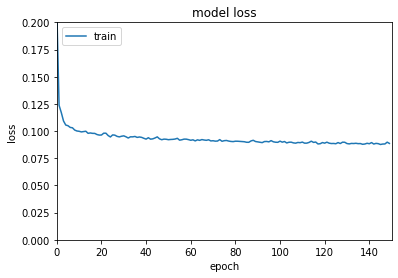

In [2]:
parsee = ct_sheet.sheet_names[0]
data = ct_sheet.parse(parsee)
data_features = data.loc[:, data.columns] 
data_features = data_features.drop(['ROI',11142,12142], axis=1)  

parsee2 = ct_sheet.sheet_names[1]
data2 = ct_sheet.parse(parsee2)
data_labels = data2.loc[:, data2.columns] 
data_labels = data_labels.drop(['ROI',11142,12142], axis=1)  
#Get rid of subject names to only have features now. #Need to remove ROIs. They don't convert to floats.
#Get rid of ctx_rh_Medial_wall and ctx_lh_Medial_wall, not needed for analysis.
scaler_filename = "IBIS_scaledCT1y.save"
scaler = joblib.load(scaler_filename)
scaled_data_1y = scaler.transform(data_features)

scaler_filename2 = "IBIS_scaledCT2y.save"
scaler2 = joblib.load(scaler_filename2)
scaled_data_2y = scaler.transform(data_labels)
print(scaled_data_1y.shape)
print(scaled_data_2y.shape)

#Size of encoded representation
#{'batch_size': 20, 'dropout': 0.2, 'encoded_layer_size': 25, 'epochs': 150, 'layer1_size': 100, 'layer2_size': 25}
input_size = 148
hidden_size = 100
hidden_size_2 = 25
encoding_dim = 25
dropout = 0.2

# Input Placeholder
input_data = Input(shape=(input_size,))
print(input_data)
# "encoded" is the encoded representation of the input
hidden_e_1 = Dense(hidden_size, activation='tanh')(input_data) 
hidden_e_2 = Dense(hidden_size_2, activation='tanh')(hidden_e_1)
dropout_layer = Dropout(dropout)(hidden_e_2)
encoded = Dense(encoding_dim, activation='tanh')(dropout_layer)
# "decoded" is the lossy reconstruction of the input
hidden_d_1 = Dense(hidden_size, activation='tanh')(encoded)
dropout_layer_d = Dropout(dropout)(hidden_d_1)
hidden_d_2 = Dense(hidden_size, activation='tanh')(dropout_layer_d)
decoded = Dense(input_size, activation='tanh')(hidden_d_2) 
# this model maps an input to its prediction
autoencoder = Model(input_data, decoded)
# configure our model to use mean_absolute_error loss function, and the Adam optimizer:
autoencoder.compile(optimizer='Adam', loss='mean_absolute_error')

ac = autoencoder.fit(scaled_data_2y, scaled_data_1y,
epochs=150,
batch_size=20,
shuffle=True)

#print(ac.history.keys())
# "Loss"
plt.plot(ac.history['loss'])
#plt.plot(ac.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
#plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, 150, 0.0, 0.2])
plt.show()

In [3]:
autoencoder.save("Autoencoder Input 2 year Output 1 year CT")

In [4]:
ct_sheet_2y = pd.ExcelFile("Data to be Interpolated.xlsx") 
parsee = ct_sheet_2y.sheet_names[5]
print(parsee)
data = ct_sheet_2y.parse(parsee)
data_features_ct2y = data.loc[:, data.columns] 
data_features_ct2y = data_features_ct2y.drop(['ROI',11142,12142], axis=1)
scaled_data_ct2y = scaler2.transform(data_features_ct2y)
print(scaled_data_ct2y.shape)

predicted_1yr_ct = autoencoder.predict(scaled_data_ct2y)

2Y CT
(20, 148)


In [5]:
print(predicted_1yr_ct)

[[ 0.6332035   0.50006646  0.57114774 ...  0.46882164  0.46911532
   0.4327111 ]
 [-0.34524107 -0.03065688  0.13512446 ... -0.19320163 -0.3701779
   0.10696103]
 [-0.05960761  0.05314299  0.14814557 ... -0.05833349 -0.28801063
   0.09480355]
 ...
 [ 0.01660283  0.16953766  0.20470393 ...  0.03244777 -0.18424323
   0.16416128]
 [-0.15649265  0.14762788  0.24322906 ... -0.07000566 -0.20398378
   0.1550608 ]
 [-0.12572294  0.10681565  0.12825173 ... -0.03611445 -0.20237513
   0.17343535]]


In [6]:
df = pd.DataFrame(predicted_1yr_ct)
df.to_excel("Interpolated CT 1y.xlsx", index=False)

In [7]:
df

,0,1,2,3,4,5,6,7,8,9,...,138,139,140,141,142,143,144,145,146,147
0,0.633204,0.500066,0.571148,0.653715,0.598459,0.755616,0.604603,0.533076,0.568695,0.570229,...,0.637455,0.524194,0.397115,0.471500,0.561303,0.804900,0.466915,0.468822,0.469115,0.432711
1,-0.345241,-0.030657,0.135124,-0.042443,-0.276815,0.248235,0.056493,-0.267335,-0.026539,-0.137934,...,-0.059306,0.071699,-0.151146,-0.110233,0.148461,0.064440,-0.430663,-0.193202,-0.370178,0.106961
2,-0.059608,0.053143,0.148146,0.115841,-0.069659,0.325438,0.055484,-0.221650,0.045406,-0.075505,...,-0.006122,0.077620,-0.122246,-0.042713,0.177038,0.333489,-0.376331,-0.058333,-0.288011,0.094804
3,-0.098709,0.121213,0.255222,0.206924,-0.104062,0.412454,0.207333,-0.018501,0.246705,0.180000,...,0.256870,0.358515,-0.026240,0.032454,0.248710,0.340618,-0.230151,-0.041986,-0.142446,0.205055
4,-0.196298,-0.048596,0.108206,0.005174,-0.185726,0.279652,0.043221,-0.236393,0.081146,-0.036828,...,-0.041913,0.167597,-0.162967,-0.076082,0.162751,0.206135,-0.366942,-0.126038,-0.318888,0.088399
5,-0.214302,0.005120,0.075802,0.037431,-0.218483,0.331024,0.097427,-0.237222,0.097479,0.064496,...,0.019833,0.241470,-0.157935,-0.075652,0.142014,0.196229,-0.340456,-0.108270,-0.302400,0.122740
6,-0.180532,0.067086,0.181357,0.142417,-0.183661,0.313881,0.120228,-0.201511,0.102114,0.083134,...,0.005705,0.211951,-0.074239,-0.024620,0.214816,0.183931,-0.295259,-0.071084,-0.213549,0.172659
7,-0.293331,0.017522,0.097288,-0.055954,-0.274845,0.250720,0.042443,-0.248596,0.049488,-0.072084,...,-0.046876,0.100378,-0.164210,-0.117768,0.115267,0.129506,-0.395353,-0.169608,-0.351799,0.068215
8,-0.222410,-0.057488,0.114284,0.056716,-0.213370,0.293207,0.089664,-0.240399,0.047521,0.025372,...,0.019973,0.173605,-0.160289,-0.074095,0.154086,0.184744,-0.370811,-0.132954,-0.277153,0.154341
9,-0.161700,0.089911,0.147831,0.089532,-0.161420,0.324618,0.130719,-0.192992,0.084728,0.068793,...,0.099094,0.185579,-0.105667,-0.024891,0.178059,0.239527,-0.339667,-0.083513,-0.232487,0.134911


In [8]:
#Now calculate MAE on the original Gilmore Dataset
gilmore_sheet = pd.ExcelFile("Gilmore CT1y2y SA1y2y.xlsx") 
parsee = gilmore_sheet.sheet_names[2] #ct2y
print(parsee)
data = gilmore_sheet.parse(parsee)
data_features_ct2y = data.loc[:, data.columns] 
data_features_ct2y = data_features_ct2y.drop(['ROI'], axis=1)
scaled_data_ct2y_gilmore = scaler2.transform(data_features_ct2y)
print(scaled_data_ct2y_gilmore.shape)

predicted_1yr_ct_gilmore = autoencoder.predict(scaled_data_ct2y_gilmore)
df = pd.DataFrame(predicted_1yr_ct_gilmore)
df.to_excel("Interpolated CT 1y Gilmore Scaled.xlsx", index=False) #Don't necessarily need this sheet, but good to have

CT2y
(188, 148)


In [9]:
#Inverse Transform the predicted data to calculate MAE
unscaled_predicted_ct1y = scaler.inverse_transform(predicted_1yr_ct_gilmore)
type(unscaled_predicted_ct1y)
df = pd.DataFrame(unscaled_predicted_ct1y)
df.to_excel("Interpolated CT 1y Gilmore.xlsx", index=False)